In [1]:
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import pandas as pd

import matplotlib.pyplot as plt  # plotting library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list

import cftime

In [2]:
# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

In [3]:
#To compute de climatoloy
yearC1='2004'
yearC2='2009'

## Read the data

In [4]:
DC=xr.open_dataset('./Data/RG_Global_2004-01_2024-03.nc')

In [5]:
DC_temp=DC.temperature.sel(lat=slice( -60, 60))
DC_salt=DC.salinity.sel(lat=slice( -60, 60))

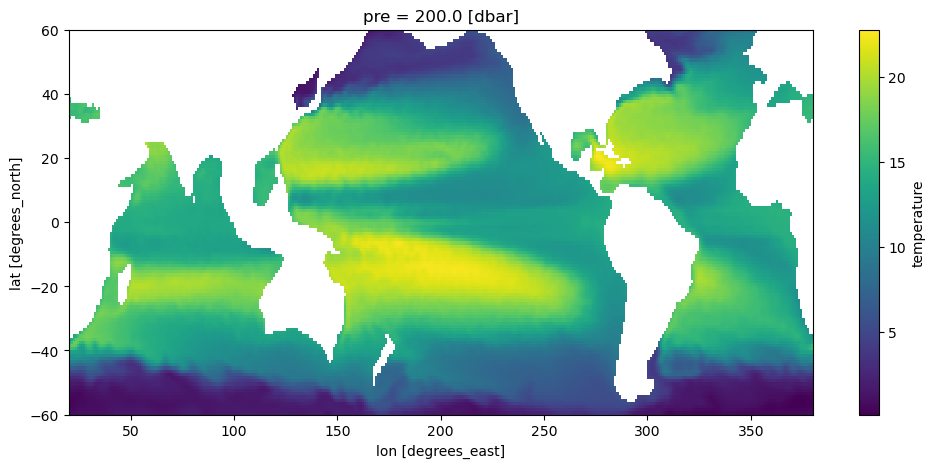

In [6]:
DC_temp.mean('time').sel(pre=200, method='nearest').plot()

In [7]:
DC

<xarray.Dataset> Size: 6GB
Dimensions:      (lon: 360, lat: 145, pre: 58, time: 243)
Coordinates:
  * lon          (lon) float32 1kB 20.5 21.5 22.5 23.5 ... 377.5 378.5 379.5
  * lat          (lat) float32 580B -64.5 -63.5 -62.5 -61.5 ... 77.5 78.5 79.5
  * pre          (pre) float32 232B 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
  * time         (time) datetime64[ns] 2kB 2004-01-15 2004-02-15 ... 2024-03-15
Data variables:
    temperature  (time, pre, lat, lon) float32 3GB ...
    salinity     (time, pre, lat, lon) float32 3GB ...

## Seasonal cycle
Create seasonal climatology from 1982 to 1992 and the asociated anomaly

In [8]:
#Create monthly climatology
DC_temp_clim = DC_temp.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();
DC_salt_clim = DC_salt.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

#Create anomaly
DC_temp_anom = DC_temp.groupby('time.month') - DC_temp_clim
DC_temp_anom.load();

DC_salt_anom = DC_salt.groupby('time.month') - DC_salt_clim
DC_salt_anom.load();

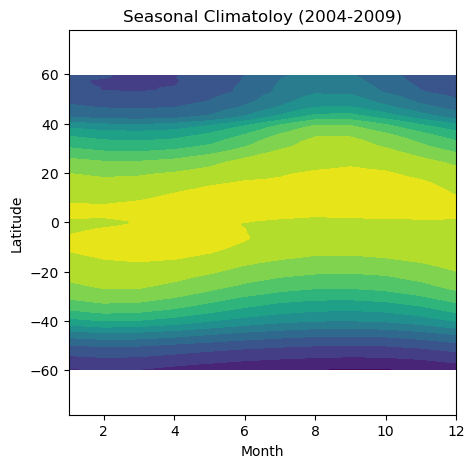

In [9]:
fig, ax = plt.subplots(1, 1 , figsize=(5,5))
ax.contourf(DC_temp_clim.mean(dim='lon').sel(pre=10, method='nearest').month,
                 DC_temp_clim.mean(dim='lon').sel(pre=10, method='nearest').lat,
                 DC_temp_clim.mean(dim='lon').sel(pre=10, method='nearest').transpose(),
            levels=12, vmin=-2, vmax=30)
ax.set_ylim(-78,78)
ax.grid()
ax.set_title('Seasonal Climatoloy (' + yearC1 + '-' + yearC2 + ')')
ax.set_ylabel('Latitude') 
ax.set_xlabel('Month')
ax.grid()

# Weighted

In [10]:
weights = np.cos(np.deg2rad(DC.temperature.lat))
weights = weights/weights.max()
weights.name = "weights"
DC_temp_weighted = DC_temp.weighted(weights)
DC_salt_weighted = DC_salt.weighted(weights)
DC_temp_anom_weighted = DC_temp_anom.weighted(weights)
DC_salt_anom_weighted = DC_salt_anom.weighted(weights)


DC_temp_wmean = DC_temp_weighted.mean(("lon", "lat"),skipna=True).load()
DC_salt_wmean = DC_salt_weighted.mean(("lon", "lat"),skipna=True).load()

DC_temp_anom_wmean = DC_temp_anom_weighted.mean(("lon", "lat"),skipna=True).load()
DC_salt_anom_wmean = DC_salt_anom_weighted.mean(("lon", "lat"),skipna=True).load()

## smoothed versions

In [11]:
DC_temp_wmean_rolling = DC_temp_wmean.rolling(time=12,center=True).mean()
DC_salt_wmean_rolling = DC_salt_wmean.rolling(time=12,center=True).mean()

DC_temp_anom_wmean_rolling = DC_temp_anom_wmean.rolling(time=12,center=True).mean()
DC_salt_anom_wmean_rolling = DC_salt_anom_wmean.rolling(time=12,center=True).mean()

## Global mean

In [12]:
Posiciones=[(0.10, 0.65, 0.8, 0.22),
            (0.10, 0.48, 0.8, 0.165),
            (0.10, 0.10, 0.8, 0.378)]

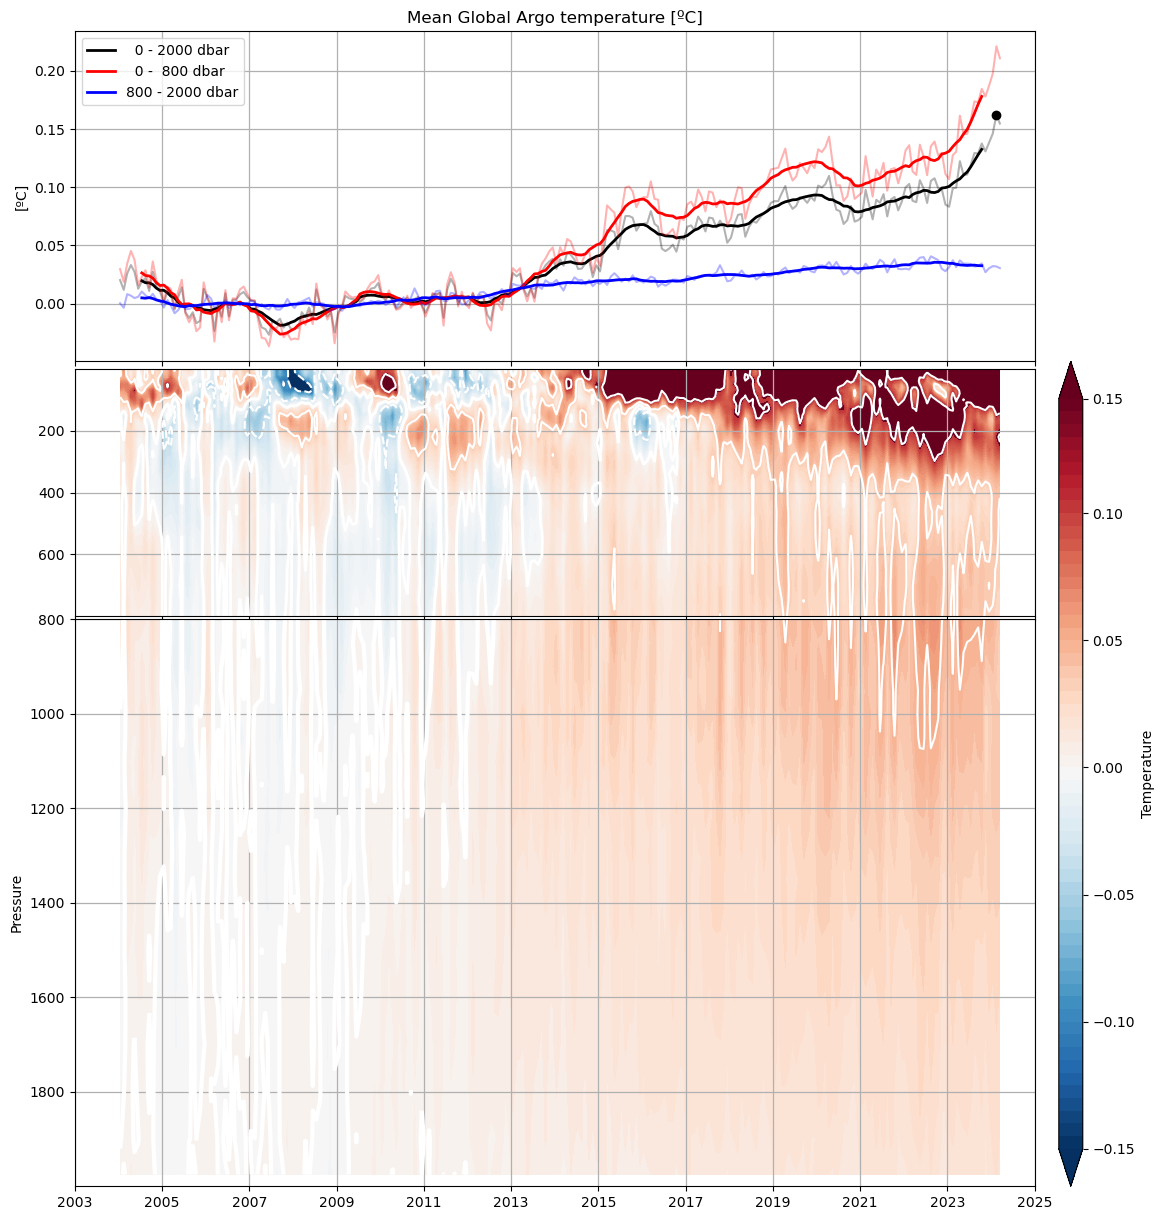

In [13]:
fig, ax = plt.subplots(3,1,figsize = (12,15),sharex=True)


# Mean values
ax[0].plot(DC_temp_anom_wmean.time,
           DC_temp_anom_wmean.sel(pre=slice(0,2000)).mean("pre"),color='k',alpha=0.3)
ax[0].plot(DC_temp_anom_wmean.time[-2],
           DC_temp_anom_wmean.sel(pre=slice(0,2000)).mean("pre")[-2],'ko')
ax[0].plot(DC_temp_anom_wmean_rolling.time,
           DC_temp_anom_wmean_rolling.sel(pre=slice(0,2000)).mean("pre"),linewidth=2,color='k',  label= '  0 - 2000 dbar')


ax[0].plot(DC_temp_anom_wmean.time,
           DC_temp_anom_wmean.sel(pre=slice(0,800)).mean("pre"),color='r',alpha=0.3)
ax[0].plot(DC_temp_anom_wmean_rolling.time,
           DC_temp_anom_wmean_rolling.sel(pre=slice(0,800)).mean("pre"),linewidth=2,color='r' ,  label= '  0 -  800 dbar')

ax[0].plot(DC_temp_anom_wmean.time,
           DC_temp_anom_wmean.sel(pre=slice(800,2000)).mean("pre"),color='b',alpha=0.3)
ax[0].plot(DC_temp_anom_wmean_rolling.time,
           DC_temp_anom_wmean_rolling.sel(pre=slice(800,2000)).mean("pre"),linewidth=2,color='b',label= '800 - 2000 dbar')
ax[0].grid(linestyle='-', linewidth=.9)
ax[0].set_position(Posiciones[0])
ax[0].legend()
ax[0].set_ylabel('[ºC]')
ax[0].set_title('Mean Global Argo temperature [ºC]')

# UpperOcean
ax[1].contour(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(0,800)).pre, 
              DC_temp_anom_wmean.sel(pre=slice(0,800)).transpose()
              ,colors='w',levels=[-0.15, -0.05, 0.05, 0.15] )
ax[1].contour(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(0,800)).pre, 
              DC_temp_anom_wmean.sel(pre=slice(0,800)).transpose(),colors='w', linewidths=2,
              levels=[0] )

ax[1].contourf(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(0,800)).pre, 
              DC_temp_anom_wmean.sel(pre=slice(0,800)).transpose(),
              cmap='RdBu_r',levels=np.arange(-0.15,0.15,0.005),extend='both',vmin=-0.2, vmax=0.2)
ax[1].set_ylim(0,800)
ax[1].invert_yaxis()
ax[1].set_yticks([200,400,600])
ax[1].grid(linestyle='-', linewidth=.9)
ax[1].set_position(Posiciones[1])

ax[2].contour(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(800,2000)).pre, 
              DC_temp_anom_wmean.sel(pre=slice(800,2000)).transpose(),colors='w',
              levels=[-0.05,0.05] )
ax[2].contour(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(800,2000)).pre, 
              DC_temp_anom_wmean.sel(pre=slice(800,2000)).transpose(),colors='w', linewidths=3,
              levels=[0] )
cntr2 = ax[2].contourf(DC_temp_anom_wmean.time, DC_temp_anom_wmean.sel(pre=slice(800,2000)).pre, 
                      DC_temp_anom_wmean.sel(pre=slice(800,2000)).transpose(),
                      cmap='RdBu_r',levels=np.arange(-0.15,0.15,0.005),extend='both')
ax[2].set_ylim(800,2000)
ax[2].invert_yaxis()
ax[2].set_yticks([800,1000,1200,1400,1600,1800])
ax[2].grid(linestyle='-', linewidth=.9)
ax[2].set_position(Posiciones[2])
ax[2].set_ylabel('Pressure')

# Adding the colorbar
cbaxes = fig.add_axes([0.92, 0.1, 0.02, 0.55])  
cb = fig.colorbar(cntr2, cax=cbaxes);
cbaxes.set_yticks([-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15])
cbaxes.set_ylabel('Temperature')

# xtick Labels
ax[0].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));
ax[1].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));
ax[2].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));

ax[2].set_xticklabels(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN').strftime('%Y'));

### Salinity

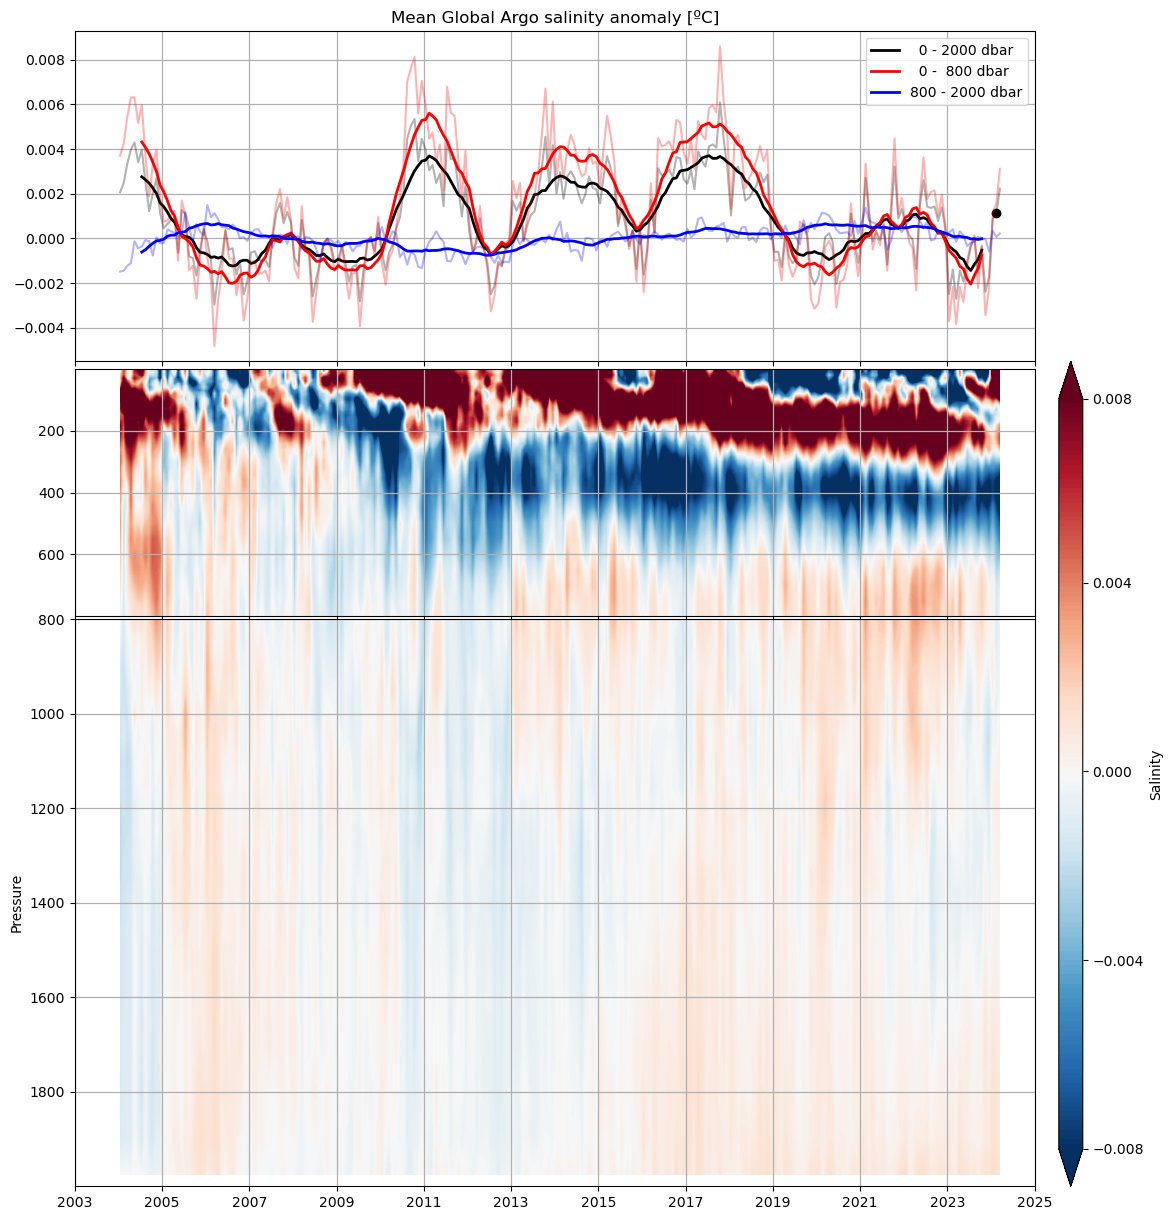

In [14]:
fig, ax = plt.subplots(3,1,figsize = (12,15),sharex=True)

# Mean values
ax[0].plot(DC_salt_anom_wmean.time,
           DC_salt_anom_wmean.sel(pre=slice(0,2000)).mean("pre"),color='k',alpha=0.3)
ax[0].plot(DC_salt_anom_wmean.time[-2],
           DC_salt_anom_wmean.sel(pre=slice(0,2000)).mean("pre")[-2],'ko')
ax[0].plot(DC_salt_anom_wmean_rolling.time,
           DC_salt_anom_wmean_rolling.sel(pre=slice(0,2000)).mean("pre"),linewidth=2,color='k',  label= '  0 - 2000 dbar')


ax[0].plot(DC_salt_anom_wmean.time,
           DC_salt_anom_wmean.sel(pre=slice(0,800)).mean("pre"),color='r',alpha=0.3)
ax[0].plot(DC_salt_anom_wmean_rolling.time,
           DC_salt_anom_wmean_rolling.sel(pre=slice(0,800)).mean("pre"),linewidth=2,color='r' ,  label= '  0 -  800 dbar')

ax[0].plot(DC_salt_anom_wmean.time,
           DC_salt_anom_wmean.sel(pre=slice(800,2000)).mean("pre"),color='b',alpha=0.3)
ax[0].plot(DC_salt_anom_wmean_rolling.time,
           DC_salt_anom_wmean_rolling.sel(pre=slice(800,2000)).mean("pre"),linewidth=2,color='b',label= '800 - 2000 dbar')

ax[0].grid(linestyle='-', linewidth=.9)
ax[0].set_position(Posiciones[0])
ax[0].legend()
ax[2].set_ylabel('[ºC]')
ax[0].set_title('Mean Global Argo salinity anomaly [ºC]')

ax[1].contourf(DC_salt_anom_wmean.time, DC_salt_anom_wmean.sel(pre=slice(0,800)).pre, 
                      DC_salt_anom_wmean.sel(pre=slice(0,800)).transpose(),20,cmap='RdBu_r',levels=np.arange(-0.008,.008,0.0001),extend='both')
ax[1].invert_yaxis()
ax[1].grid(linestyle='-', linewidth=.9)
ax[1].set_ylim(0,800)
ax[1].invert_yaxis()
ax[1].set_yticks([200,400,600])
ax[1].grid(linestyle='-', linewidth=.9)
ax[1].set_position(Posiciones[1])

cntr2 = ax[2].contourf(DC_salt_anom_wmean.time, DC_salt_anom_wmean.sel(pre=slice(800,2000)).pre, 
                      DC_salt_anom_wmean.sel(pre=slice(800,2000)).transpose(),20,cmap='RdBu_r',levels=np.arange(-0.008,.008,0.0001),extend='both')
ax[2].invert_yaxis()
ax[2].grid(linestyle='-', linewidth=.9)
ax[2].set_position(Posiciones[2])
ax[2].set_ylim(800,2000)
ax[2].invert_yaxis()
ax[2].set_yticks([800,1000,1200,1400,1600,1800])
ax[2].grid(linestyle='-', linewidth=.9)
ax[2].set_position(Posiciones[2])
ax[2].set_ylabel('Pressure')

# Adding the colorbar
cbaxes = fig.add_axes([0.92, 0.1, 0.02, 0.55])  
cb = fig.colorbar(cntr2, cax=cbaxes);
cbaxes.set_yticks([-0.008, -0.004,  0, 0.004, .008])
cbaxes.set_ylabel('Salinity')

# xtick Labels
ax[0].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));
ax[1].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));
ax[2].set_xticks(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN'));

ax[2].set_xticklabels(pd.date_range(start="2003-01-01", end="2025-01-01",freq='2YS-JAN').strftime('%Y'));


Text(0.5, 1.0, 'Mean Global Argo temperature [ºC]')

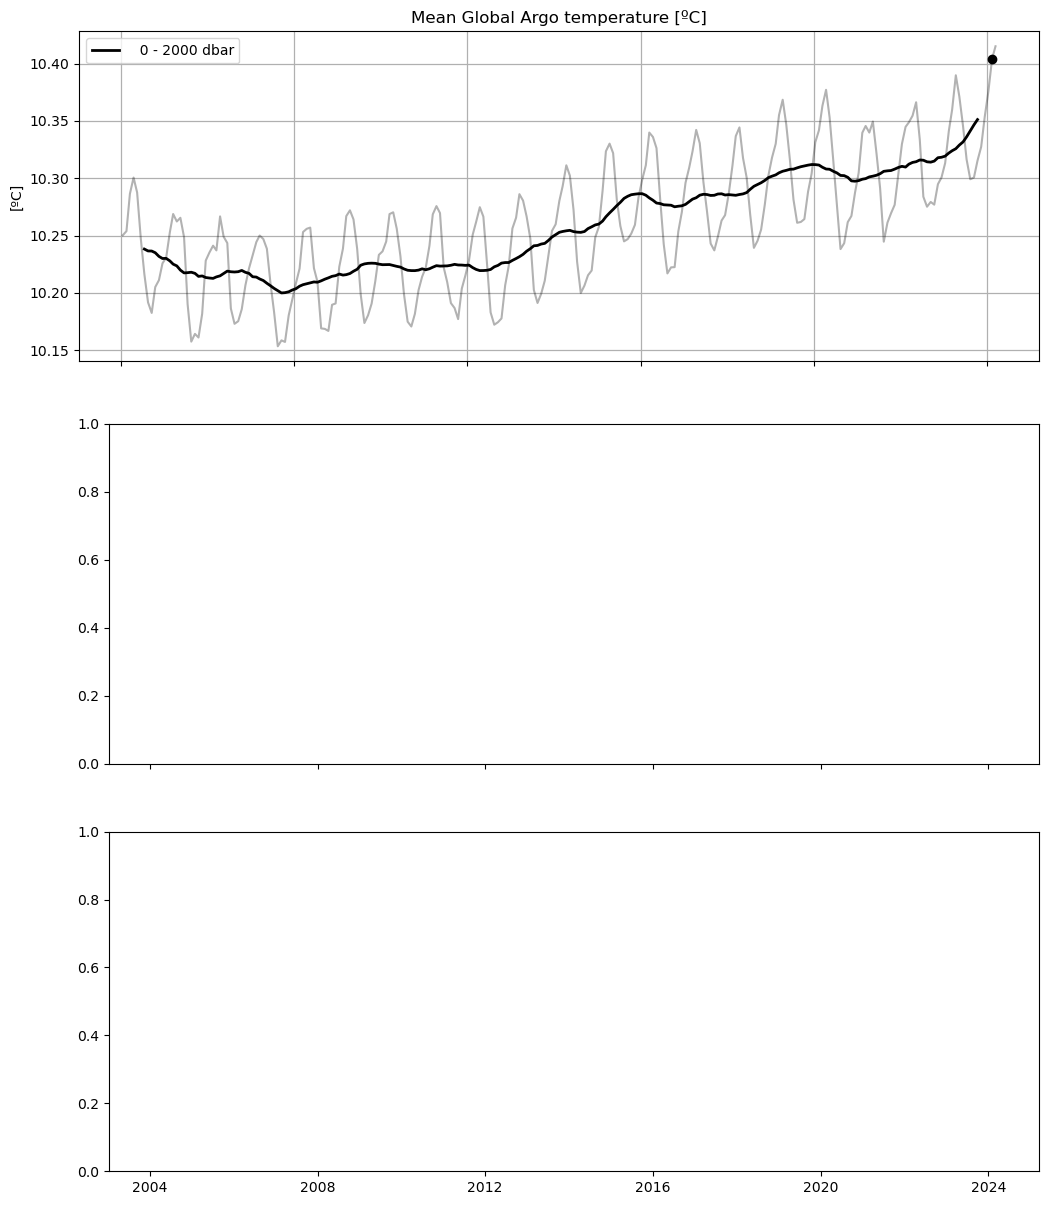

In [15]:
fig, ax = plt.subplots(3,1,figsize = (12,15),sharex=True)


# Mean values
ax[0].plot(DC_temp_wmean.time,
           DC_temp_wmean.sel(pre=slice(0,2000)).mean("pre"),color='k',alpha=0.3)
ax[0].plot(DC_temp_wmean.time[-2],
           DC_temp_wmean.sel(pre=slice(0,2000)).mean("pre")[-2],'ko')
ax[0].plot(DC_temp_wmean_rolling.time,
           DC_temp_wmean_rolling.sel(pre=slice(0,2000)).mean("pre"),linewidth=2,color='k',  label= '  0 - 2000 dbar')

ax[0].grid(linestyle='-', linewidth=.9)
ax[0].set_position(Posiciones[0])
ax[0].legend()
ax[0].set_ylabel('[ºC]')
ax[0].set_title('Mean Global Argo temperature [ºC]')


In [33]:
def calc_ocean_heat(delta_level, temperature):
    rho = 1026 #kg/m^3
    c_p = 3990 #J/(kg K)
    weighted_temperature = delta_level * temperature
    heat = weighted_temperature.sum(dim="pre")*rho*c_p
    return heat

In [45]:
heatUO = calc_ocean_heat(np.diff(np.append([0], DC_temp_wmean.pre.sel(pre=slice(0,800)).values )), 
                       DC_temp_anom_wmean.sel(pre=slice(0,800))+273)

In [43]:
heat

<xarray.DataArray 'temperature' (time: 243)> Size: 2kB
array([8.94146995e+11, 8.94085793e+11, 8.94161632e+11, 8.94186936e+11,
       8.94152927e+11, 8.94114419e+11, 8.94124030e+11, 8.94148662e+11,
       8.94095092e+11, 8.94157364e+11, 8.94116388e+11, 8.94094746e+11,
       8.94041348e+11, 8.94082236e+11, 8.94066055e+11, 8.94039783e+11,
       8.94061265e+11, 8.94111890e+11, 8.94032419e+11, 8.94014041e+11,
       8.94048164e+11, 8.94018602e+11, 8.94026519e+11, 8.94116311e+11,
       8.94100805e+11, 8.94085637e+11, 8.93986738e+11, 8.94068625e+11,
       8.94041127e+11, 8.94100238e+11, 8.94042030e+11, 8.94085154e+11,
       8.94073012e+11, 8.94096790e+11, 8.94115000e+11, 8.94085637e+11,
       8.94080767e+11, 8.94092078e+11, 8.94036262e+11, 8.94013138e+11,
       8.94008493e+11, 8.93983459e+11, 8.94042271e+11, 8.94024993e+11,
       8.94044155e+11, 8.94019824e+11, 8.94041469e+11, 8.94037569e+11,
       8.94021147e+11, 8.94031430e+11, 8.94092747e+11, 8.94049630e+11,
       8.94092583e+11, 8.94051698e+11, 8.94135481e+11, 8.94097482e+11,
       8.94087658e+11, 8.94049639e+11, 8.94053542e+11, 8.93993698e+11,
       8.94045833e+11, 8.94059722e+11, 8.94093462e+11, 8.94078785e+11,
       8.94080501e+11, 8.94075191e+11, 8.94060665e+11, 8.94066564e+11,
       8.94088815e+11, 8.94094677e+11, 8.94083978e+11, 8.94108935e+11,
       8.94049749e+11, 8.94023310e+11, 8.94037820e+11, 8.94039993e+11,
       8.94002541e+11, 8.94069182e+11, 8.94078116e+11, 8.94088534e+11,
...
       8.94248487e+11, 8.94290449e+11, 8.94267502e+11, 8.94221250e+11,
       8.94220099e+11, 8.94275338e+11, 8.94292591e+11, 8.94304885e+11,
       8.94237361e+11, 8.94269568e+11, 8.94304853e+11, 8.94289937e+11,
       8.94308141e+11, 8.94301456e+11, 8.94305440e+11, 8.94331584e+11,
       8.94327345e+11, 8.94340456e+11, 8.94349963e+11, 8.94386910e+11,
       8.94326000e+11, 8.94301383e+11, 8.94304776e+11, 8.94319647e+11,
       8.94332196e+11, 8.94316876e+11, 8.94334766e+11, 8.94334452e+11,
       8.94362588e+11, 8.94344184e+11, 8.94334163e+11, 8.94389319e+11,
       8.94332145e+11, 8.94307323e+11, 8.94298174e+11, 8.94251482e+11,
       8.94280909e+11, 8.94337587e+11, 8.94290522e+11, 8.94289487e+11,
       8.94304798e+11, 8.94394089e+11, 8.94326631e+11, 8.94292044e+11,
       8.94345810e+11, 8.94352429e+11, 8.94374795e+11, 8.94301740e+11,
       8.94353855e+11, 8.94378690e+11, 8.94331226e+11, 8.94358334e+11,
       8.94382735e+11, 8.94366990e+11, 8.94332581e+11, 8.94342687e+11,
       8.94419967e+11, 8.94406478e+11, 8.94362585e+11, 8.94417568e+11,
       8.94434922e+11, 8.94405908e+11, 8.94405712e+11, 8.94332299e+11,
       8.94317195e+11, 8.94373244e+11, 8.94355475e+11, 8.94429272e+11,
       8.94388449e+11, 8.94385838e+11, 8.94414638e+11, 8.94437172e+11,
       8.94428506e+11, 8.94458612e+11, 8.94433994e+11, 8.94449115e+11,
       8.94471596e+11, 8.94517358e+11, 8.94493013e+11])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2004-01-15 2004-02-15 ... 2024-03-15
    month    (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 11 ... 6 7 8 9 10 11 12 1 2 3

array([  2.5,   7.5,  10. ,  10. ,  10. ,  10. ,  10. ,  10. ,  10. ,
        10. ,  10. ,  10. ,  10. ,  10. ,  10. ,  10. ,  10. ,  10. ,
        12.5,  17.5,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,
        20. ,  20. ,  20. ,  20. ,  20. ,  22.5,  37.5,  50. ,  50. ,
        50. ,  50. ,  50. ,  50. ,  50. ,  50. ,  50. ,  50. ,  50. ,
        50. ,  50. ,  50. ,  50. ,  50. ,  50. ,  62.5,  87.5, 100. ,
       100. , 100. , 100. ,  75. ])